## Import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import re

import pandas as pd
import seaborn as sns

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib

from pathlib import Path

font = {'family': 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

## Config

In [2]:
data_root = 'data/results/aggreg'

extra_data = {
    'montage-chameleon-2mass-025d-001': { 'workflow_size': 619 },
    'montage-chameleon-dss-10d-001':    { 'workflow_size': 472 },
    'montage-chameleon-2mass-015d-001': { 'workflow_size': 310 },
    'montage-chameleon-dss-075d-001':   { 'workflow_size': 178 },
    'montage-chameleon-2mass-01d-001':  { 'workflow_size': 103 },
    'montage-chameleon-dss-05d-001':    { 'workflow_size': 58 },
}

# fifo | heft | min_min
sched_alg_name = 'fifo'

y_name = 'diff_abs'
y_units = 's'

x_name = 'workflow_size'
x_units = ''

hue_name = 'sys_cores'
hue_order = [8, 16, 24]

# y_label = f'{y_name} ({y_units})'
y_label = f'NUMA Impact ({y_units})'
x_label = ''

col_name = 'workflow_group_name'
col_order = ['C', 'S', 'L']
col_template="{col_name}"

base_conf_name = 'SL'
test_conf_name = 'MA'

derivated_cols = {
    'read_time_total_avg': lambda row : row['read_time_total_mean'] / row['read_accesses_total_mean']
}

derivated_cols_pivot = {
    'diff_abs': lambda row : abs(row[base_conf_name] - row[test_conf_name])
}

# Comment if no figure is required
fig_output_file = f'{sched_alg_name}_{y_name}_{y_units}.pdf'

## Helpers

In [3]:
def extract_data_to_dataframe(path, extra_data=None):
    series = pd.read_csv(path, header=None, index_col=0).iloc[:, 0]

    # Normalize path and split it
    parts = os.path.normpath(path).split(os.sep)

    # Extract workflow group
    workflow_group_name = parts[3].split('_')[0]

    # Extract workflow name
    workflow_name = parts[3].split('_')[1]

    # Example: 'min_min_16' → sched_alg_name = min_min, sys_cores = 16
    sched_part = parts[4]
    sched_alg_name, sys_cores = sched_part.rsplit('_', 1)

    # Extract test config name
    filename = os.path.splitext(parts[5])[0]
    test_conf_name = filename.split('_')[1]

    data = {
        'workflow_group_name': workflow_group_name,
        'workflow_name': workflow_name,
        'test_conf_name': test_conf_name,
        'sched_alg_name': sched_alg_name,
        'sys_cores': int(sys_cores)
    }

    df = pd.concat([series, pd.Series(data)]).to_frame().T

    if extra_data:
        df = df.assign(**extra_data[workflow_name])

    return df

## Dataframe

In [4]:
test_conf_names = list(Path(data_root).rglob('*.csv'))
df = pd.concat([ extract_data_to_dataframe(f, extra_data) for f in test_conf_names ])

df_cond = (df["sched_alg_name"] == sched_alg_name) & (df["test_conf_name"].isin([base_conf_name, test_conf_name]))
df = df[df_cond].copy()

for k, v in derivated_cols.items():
    df[k] = df.apply(v, axis=1)

df = df[['workflow_group_name','workflow_size', 'test_conf_name', 'sys_cores', 'read_time_total_avg']].reset_index(drop=True)
pivot_df = df.pivot(index=['workflow_group_name','workflow_size', 'sys_cores'], columns='test_conf_name', values='read_time_total_avg')

for k, v in derivated_cols_pivot.items():
    pivot_df[k] = pivot_df.apply(v, axis=1)

result = pivot_df.reset_index()
result.head()

test_conf_name,workflow_group_name,workflow_size,sys_cores,MA,SL,diff_abs
0,C,58,8,0.080398,0.072256,0.008142
1,C,58,16,0.073283,0.072583,0.000699
2,C,58,24,0.079222,0.072613,0.006609
3,C,103,8,0.085995,0.072003,0.013991
4,C,103,16,0.078796,0.072495,0.006301


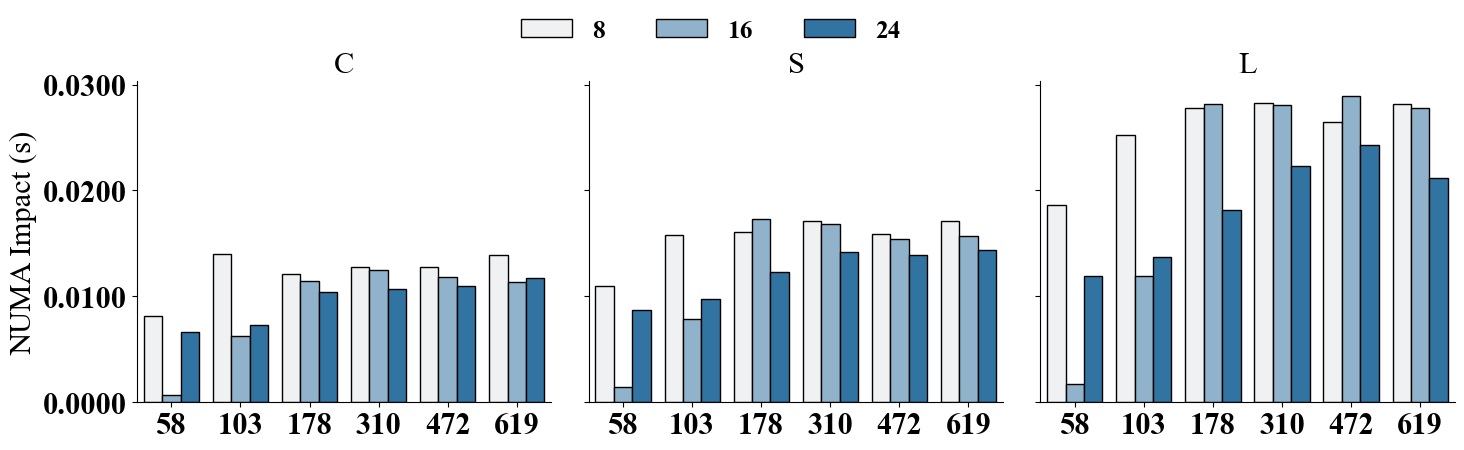

In [5]:
g = sns.FacetGrid(result, col=col_name, col_order=col_order, col_wrap=3, height=5, sharex=False, sharey=True)

# Map barplot to each facet
g.map_dataframe(sns.barplot, x=x_name, y=y_name, hue=hue_name, hue_order=hue_order, edgecolor='black')

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))

g.add_legend(title='', bbox_to_anchor=(0.5, 0.95), ncol=9, framealpha=0, fontsize='small')
g.set_titles(col_template=col_template)
g.set_axis_labels(x_label, y_label)
g.fig.subplots_adjust(top=0.85)

if 'fig_output_file' in globals():
    plt.savefig(fig_output_file, dpi=300, bbox_inches='tight')